In [ ]:
# Importando librerias a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import Rocket, MiniRocket, MultiRocket
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from fastdtw import fastdtw


## Cargando data a usar

# Cargar los archivos
earthquake_data = pd.read_csv('IMU_earthquake.csv')
extra_weigth_data = pd.read_csv('IMU_extra_weigth.csv')
hitting_arm_data = pd.read_csv('IMU_hitting_arm.csv')
hitting_platform_data = pd.read_csv('IMU_hitting_platform.csv')
magnet_data = pd.read_csv('IMU_magnet.csv')

# Agregar la columna anomaly
earthquake_data['anomaly'] = 'earthquake'
extra_weigth_data['anomaly'] = 'extra_weight'
hitting_arm_data['anomaly'] = 'hitting_arm'
hitting_platform_data['anomaly'] = 'hitting_platform'
magnet_data['anomaly'] = 'magnet'

# Juntamos todos los dataframes en uno solo
df = pd.concat([earthquake_data, extra_weigth_data, hitting_arm_data, hitting_platform_data, magnet_data], ignore_index=True)

rows, cols = df.shape
print(f"Filas: {rows}")
print(f"Columnas: {cols}")

df.head()

# --- Configuración ---
fs = 10
win_sec = 2
win_size = fs * win_sec

sensor_cols = ['accX','accY','accZ',
               'gyroX','gyroY','gyroZ',
               'magX','magY','magZ']

# Crera ventanas para ROCKET
def create_windows(df, label):
    data = df[sensor_cols].values
    n = len(data)

    windows, labels = [], []

    for i in range(0, n - win_size, win_size):
        w = data[i:i+win_size]
        windows.append(w)
        labels.append(label)

    return windows, labels

# Crear dataset ventaneado
X_list, y_list = [], []

for anomaly in df["anomaly"].unique():
    subset = df[df["anomaly"] == anomaly]
    w, lab = create_windows(subset, anomaly)
    X_list.extend(w)
    y_list.extend(lab)

X = np.array(X_list)
y = np.array(y_list)

print("Shape X:", X.shape) 

scaler = StandardScaler()
n_samples, T, C = X.shape

X = X.reshape(-1, C)
X = scaler.fit_transform(X)
X = X.reshape(n_samples, T, C)

def to_sktime_format(X):
    rows = []
    for sample in X:
        row = {f"ch{c}": pd.Series(sample[:, c]) for c in range(sample.shape[1])}
        rows.append(row)
    return pd.DataFrame(rows)

X_sktime = to_sktime_format(X)

# Separamos los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_sktime, y, test_size=0.2, stratify=y, random_state=42
)

# Usando ROCKET y MiniROCKET para transformar las series temporales

# ROCKET
rocket = Rocket(num_kernels=3000, random_state=42)
rocket.fit(X_train)
X_train_rocket = rocket.transform(X_train)
X_test_rocket = rocket.transform(X_test)

# MiniROCKET
minirocket = MiniRocket()
minirocket.fit(X_train)
X_train_mini = minirocket.transform(X_train)
X_test_mini = minirocket.transform(X_test)

Filas: 64303
Columnas: 12
Shape X: (3213, 20, 9)


In [ ]:
def make_models():
    # Modelo de KNN
    knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')

    # Modelo SVM con penalización L1
    svm_l1 = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),  
        ("svm", LinearSVC(
            penalty="l1",
            loss="squared_hinge",
            dual=False,
            C=1.0,
            max_iter=1000
        ))
    ])

    return knn, svm_l1


# Entrenamiento ROCKET
knn_r, svm_r = make_models()
knn_r.fit(X_train_rocket, y_train)
svm_r.fit(X_train_rocket, y_train)

# Entrenamiento MiniROCKET
knn_mi, svm_mi = make_models()
knn_mi.fit(X_train_mini, y_train)
svm_mi.fit(X_train_mini, y_train)

c:\Users\Piero4512\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Piero4512\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,False
,with_std,True
,penalty,'l1'
,loss,'squared_hinge'
,dual,False
,tol,0.0001



=== ROCKET ===

KNN:

MÉTRICAS

Métrica      | earthquake   | extra_weight | hitting_arm  | hitting_platform | magnet      
-------------------------------------------------------------------------------------------
Accuracy     | 0.9518       | 0.8227       | 0.7994       | 0.8600       | 0.8383      
Precision    | 0.8074       | 0.4862       | 0.4286       | 0.6899       | 0.7374      
Recall       | 0.9561       | 0.8073       | 0.2521       | 0.7267       | 0.4834      
F1-score     | 0.8755       | 0.6069       | 0.3175       | 0.7078       | 0.5840      
None


<Figure size 700x600 with 0 Axes>

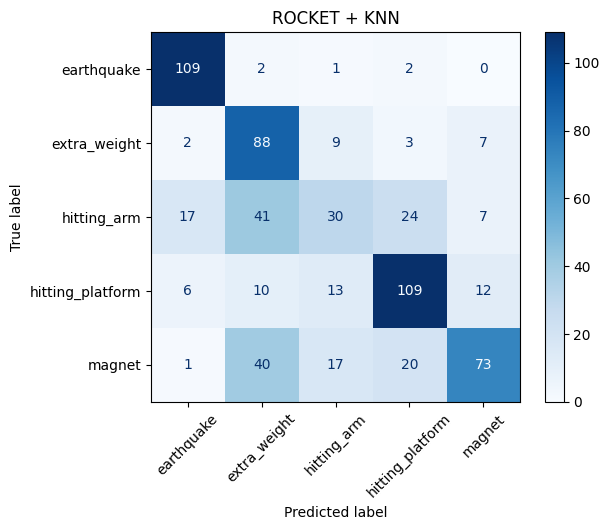


SVM:

MÉTRICAS

Métrica      | earthquake   | extra_weight | hitting_arm  | hitting_platform | magnet      
-------------------------------------------------------------------------------------------
Accuracy     | 0.9798       | 0.8320       | 0.7760       | 0.7932       | 0.8320      
Precision    | 0.9469       | 0.5046       | 0.3984       | 0.5528       | 0.6569      
Recall       | 0.9386       | 0.5046       | 0.4118       | 0.5933       | 0.5960      
F1-score     | 0.9427       | 0.5046       | 0.4050       | 0.5723       | 0.6250      
None


<Figure size 700x600 with 0 Axes>

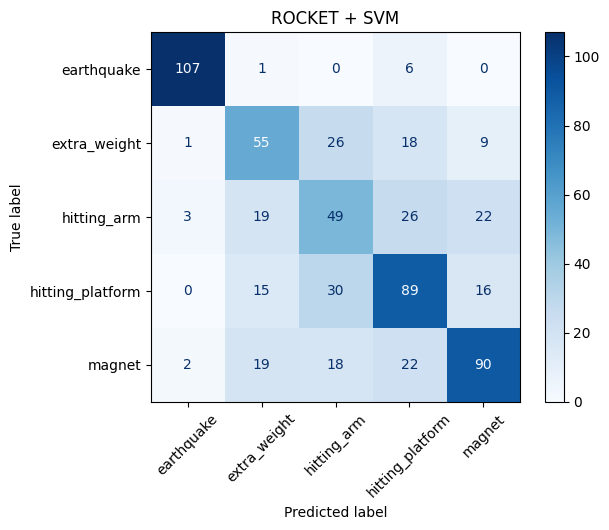


=== MiniROCKET ===

KNN:

MÉTRICAS

Métrica      | earthquake   | extra_weight | hitting_arm  | hitting_platform | magnet      
-------------------------------------------------------------------------------------------
Accuracy     | 0.9736       | 0.8896       | 0.8367       | 0.8958       | 0.9222      
Precision    | 0.8819       | 0.6092       | 0.6061       | 0.7427       | 0.9810      
Recall       | 0.9825       | 0.9725       | 0.3361       | 0.8467       | 0.6821      
F1-score     | 0.9295       | 0.7491       | 0.4324       | 0.7913       | 0.8047      
None


<Figure size 700x600 with 0 Axes>

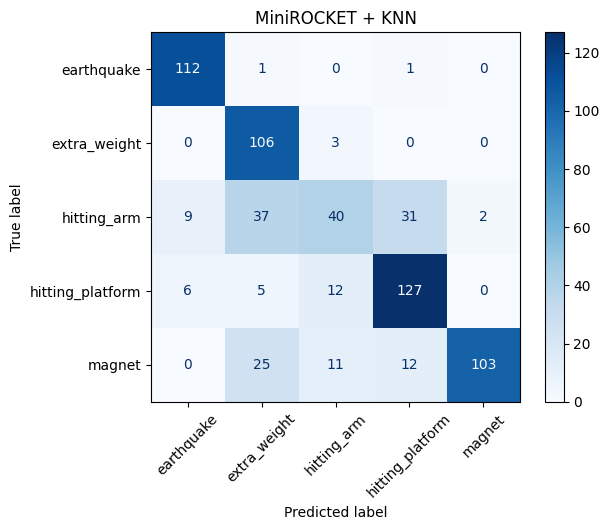


SVM:

MÉTRICAS

Métrica      | earthquake   | extra_weight | hitting_arm  | hitting_platform | magnet      
-------------------------------------------------------------------------------------------
Accuracy     | 0.9907       | 0.9362       | 0.9145       | 0.8974       | 0.9813      
Precision    | 0.9909       | 0.7615       | 0.7759       | 0.7877       | 0.9929      
Recall       | 0.9561       | 0.9083       | 0.7563       | 0.7667       | 0.9272      
F1-score     | 0.9732       | 0.8285       | 0.7660       | 0.7770       | 0.9589      
None


<Figure size 700x600 with 0 Axes>

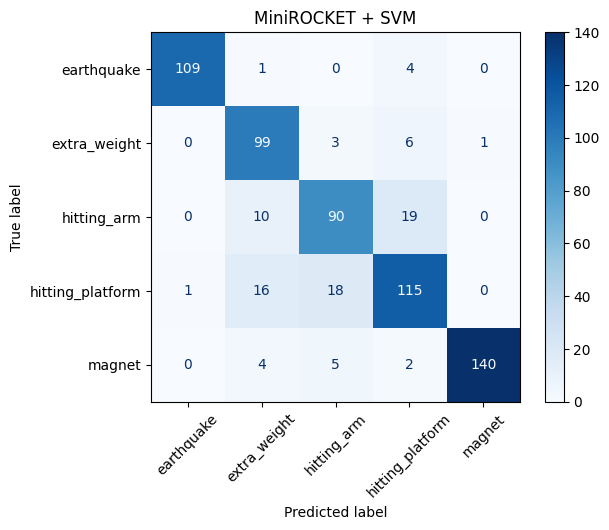

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Métricas de evaluación uno-vs-demás
def evaluar_ovr(model, X_test, y_test):
    y_pred = model.predict(X_test)
    clases = np.unique(y_test)

    # Diccionario temporal para guardar métricas
    resultados = {c: {} for c in clases}

    # Calcular métricas por clase uno-vs-demás
    for c in clases:
        y_test_bin = (y_test == c).astype(int)
        y_pred_bin = (y_pred == c).astype(int)

        resultados[c]["Accuracy"]  = accuracy_score(y_test_bin, y_pred_bin)
        resultados[c]["Precision"] = precision_score(y_test_bin, y_pred_bin, zero_division=0)
        resultados[c]["Recall"]    = recall_score(y_test_bin, y_pred_bin, zero_division=0)
        resultados[c]["F1-score"]  = f1_score(y_test_bin, y_pred_bin, zero_division=0)

    print("\nMÉTRICAS\n")

    # Definir ancho fijo por columna
    col_width = 12  

    # Encabezado
    encabezado = "Métrica".ljust(col_width) + " | " + " | ".join(
        str(c).ljust(col_width) for c in clases
    )
    print(encabezado)
    print("-" * len(encabezado))

    # Filas por métrica
    for metrica in ["Accuracy", "Precision", "Recall", "F1-score"]:
        fila = metrica.ljust(col_width) + " | "
        fila += " | ".join(f"{resultados[c][metrica]:.4f}".ljust(col_width) for c in clases)
        print(fila)


# Matriz de confusión
def plot_cm(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=np.unique(y_test)
    )
    plt.figure(figsize=(7, 6))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()



# Graficando métricas y matrices de confusión

# ROCKET
print("\n=== ROCKET ===")
print("\nKNN:")
print(evaluar_ovr(knn_r, X_test_rocket, y_test))
plot_cm(knn_r, X_test_rocket, y_test, "ROCKET + KNN")


print("\nSVM:")
print(evaluar_ovr(svm_r, X_test_rocket, y_test))
plot_cm(svm_r, X_test_rocket, y_test, "ROCKET + SVM")



# MiniROCKET
print("\n=== MiniROCKET ===")
print("\nKNN:")
print(evaluar_ovr(knn_mi, X_test_mini, y_test))
plot_cm(knn_mi, X_test_mini, y_test, "MiniROCKET + KNN")

print("\nSVM:")
print(evaluar_ovr(svm_mi, X_test_mini, y_test))
plot_cm(svm_mi, X_test_mini, y_test, "MiniROCKET + SVM")
